15:30:29 - cmdstanpy - INFO - Chain [1] start processing
15:30:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/10 [00:00<?, ?it/s]

15:30:36 - cmdstanpy - INFO - Chain [1] start processing
15:30:38 - cmdstanpy - INFO - Chain [1] done processing
15:30:40 - cmdstanpy - INFO - Chain [1] start processing
15:30:46 - cmdstanpy - INFO - Chain [1] done processing
15:30:48 - cmdstanpy - INFO - Chain [1] start processing
15:30:54 - cmdstanpy - INFO - Chain [1] done processing
15:30:57 - cmdstanpy - INFO - Chain [1] start processing
15:31:03 - cmdstanpy - INFO - Chain [1] done processing
15:31:06 - cmdstanpy - INFO - Chain [1] start processing
15:31:15 - cmdstanpy - INFO - Chain [1] done processing
15:31:18 - cmdstanpy - INFO - Chain [1] start processing
15:31:29 - cmdstanpy - INFO - Chain [1] done processing
15:31:32 - cmdstanpy - INFO - Chain [1] start processing
15:31:44 - cmdstanpy - INFO - Chain [1] done processing
15:31:49 - cmdstanpy - INFO - Chain [1] start processing
15:32:02 - cmdstanpy - INFO - Chain [1] done processing
15:32:07 - cmdstanpy - INFO - Chain [1] start processing
15:32:14 - cmdstanpy - INFO - Chain [1]

Cross-validation performance metrics:
          horizon          mse       rmse        mae      mape     mdape  \
0 3 days 02:00:00  4409.224943  66.401995  36.046704  0.023626  0.011878   
1 3 days 03:00:00  4428.803084  66.549253  36.049052  0.023637  0.011765   
2 3 days 04:00:00  4448.752817  66.698972  36.240995  0.023796  0.012094   
3 3 days 05:00:00  4465.887410  66.827295  36.411106  0.023929  0.012178   
4 3 days 06:00:00  4484.838789  66.968939  36.626734  0.024095  0.012398   

      smape  coverage  
0  0.023740  0.915835  
1  0.023759  0.917118  
2  0.023921  0.917261  
3  0.024056  0.917261  
4  0.024224  0.917261  
Validation MAPE: 0.06155064384627065


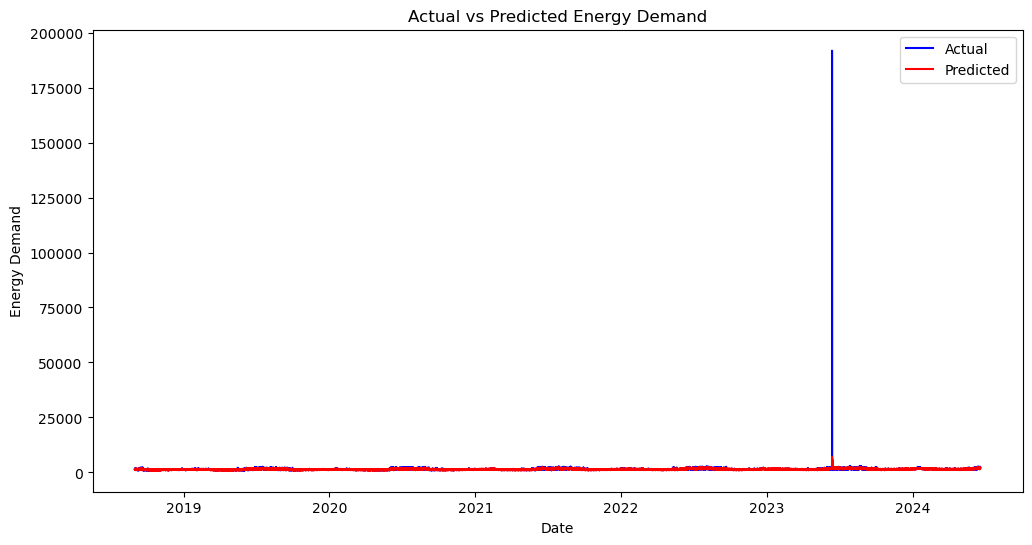

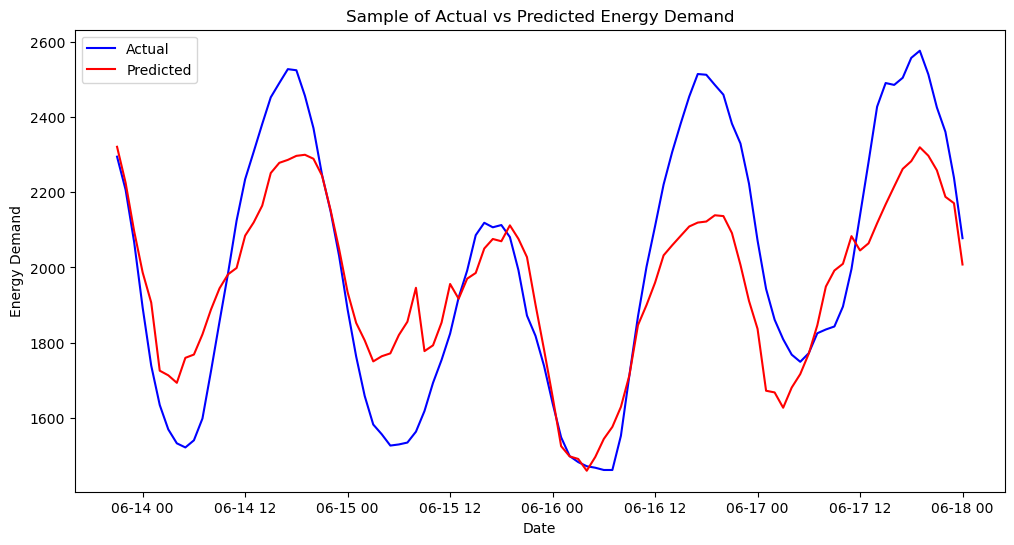

MAPE for data: 7.287326839300667


In [4]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('../City-Specific Data/Omaha.csv')
data = data.dropna()
data['Time'] = pd.to_datetime(data['time'])
data['Demand (MW)'] = data['Demand (MW)'].str.replace(',', '').astype(float)
df = data.rename(columns={'Time': 'ds', 'Demand (MW)': 'y'})

df['Hour'] = df['ds'].dt.hour
df['DayOfWeek'] = df['ds'].dt.dayofweek
df['Month'] = df['ds'].dt.month
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

for lag in range(1, 25):
    df[f'Lag_{lag}'] = df['y'].shift(lag)

df['Temp_RollingMean_24'] = df['Temperature'].rolling(window=24).mean()
df['Temp_RollingStd_24'] = df['Temperature'].rolling(window=24).std()
df['Temp_Humidity_Interaction'] = df['Temperature'] * df['RelativeHumidity']

df.dropna(inplace=True)

model = Prophet()
model.add_regressor('Temperature')
model.add_regressor('DewPoint')
model.add_regressor('WindSpeed')
model.add_regressor('Pressure')
model.add_regressor('RelativeHumidity')
model.add_regressor('Hour')
model.add_regressor('DayOfWeek')
model.add_regressor('Month')
model.add_regressor('IsWeekend')
model.add_regressor('Temp_RollingMean_24')
model.add_regressor('Temp_RollingStd_24')
model.add_regressor('Temp_Humidity_Interaction')

for lag in range(1, 25):
    model.add_regressor(f'Lag_{lag}')

model.fit(df)

df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='30 days')
df_p = performance_metrics(df_cv)
print("Cross-validation performance metrics:")
print(df_p.head())

val_df = df.iloc[-len(df_cv):]
val_df_future = val_df[['ds', 'Temperature', 'DewPoint', 'WindSpeed', 'Pressure', 'RelativeHumidity', 
                        'Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'Temp_RollingMean_24', 
                        'Temp_RollingStd_24', 'Temp_Humidity_Interaction'] + [f'Lag_{lag}' for lag in range(1, 25)]]

forecast_val = model.predict(val_df_future)
val_mape = mean_absolute_percentage_error(val_df['y'], forecast_val['yhat'])
print("Validation MAPE:", val_mape)

future = df[['ds', 'Temperature', 'DewPoint', 'WindSpeed', 'Pressure', 'RelativeHumidity', 
             'Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'Temp_RollingMean_24', 
             'Temp_RollingStd_24', 'Temp_Humidity_Interaction'] + [f'Lag_{lag}' for lag in range(1, 25)]]

forecast = model.predict(future)

df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)
aligned_df = df.join(forecast[['yhat']], how='inner')

if len(aligned_df['y']) != len(aligned_df['yhat']):
    print(f"Length mismatch: Actual = {len(aligned_df['y'])}, Predicted = {len(aligned_df['yhat'])}")

plt.figure(figsize=(12, 6))
plt.plot(aligned_df.index, aligned_df['y'], label='Actual', color='b')
plt.plot(aligned_df.index, aligned_df['yhat'], label='Predicted', color='r')
plt.title('Actual vs Predicted Energy Demand')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.legend()
plt.show()

sample_period = 100
plt.figure(figsize=(12, 6))
plt.plot(aligned_df.index[-sample_period:], aligned_df['y'].iloc[-sample_period:], label='Actual', color='b')
plt.plot(aligned_df.index[-sample_period:], aligned_df['yhat'].iloc[-sample_period:], label='Predicted', color='r')
plt.title('Sample of Actual vs Predicted Energy Demand')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.legend()
plt.show()

non_zero_data = aligned_df[aligned_df['y'] != 0]
non_zero_errors = np.abs((non_zero_data['y'] - non_zero_data['yhat']) / non_zero_data['y'])
non_zero_mape = non_zero_errors.mean() * 100
print("MAPE for data:", non_zero_mape)